# TP: From Python implemented by a user to a performant X code

You have been given the following notebook that implement a M-Layer N-N neural network and test it against a small dataset and a classic benchmark MNIST.

The code is in Python 3 written without any concerns for performance.

The goal of this TP is to improve the performance. To do so, you can :
- improve the Python code (with better numpy usage, numba, parallelism, vectorisation, cuDF, use BLAS or any linear algebra library...).
- rewrite the code in C++ or CUDA (or wathever) with or without BLAS/Linear Algebra Library

Do not forget to evaluate your code !

In [5]:
from numpy import exp, array, random, dot
import numpy as np

class NeuralNetwork():
	def __init__(self, seed, input_size, output_size, nb_layer, min_nodes_per_layer, max_nodes_per_layer, learning_rate):
		random.seed(seed)
		self.nb_layer = nb_layer
		self.learning_rate = learning_rate
		layers = np.empty(self.nb_layer, dtype=int)
		
		for i in range(self.nb_layer):
			layers[i] = random.randint(min_nodes_per_layer,max_nodes_per_layer+1)
        
        # assign random weights to matrices in network
		# format is (no. of nodes in previous layer) x (no. of nodes in following layer)
		self.synaptic_weights = {}
		for i in range(self.nb_layer+1):
			if i == 0:
				self.synaptic_weights[i] = 2 * random.random((input_size, layers[i])) -1
			elif i == self.nb_layer:
				self.synaptic_weights[i] = 2 * random.random((layers[i-1], output_size)) -1
			else:
				self.synaptic_weights[i] = 2 * random.random((layers[i-1], layers[i])) -1
		
	def __sigmoid(self, x):
		return 1/(1+exp(-x))

	# derivative of sigmoid function, indicates confidence about existing weight
	def __sigmoid_derivative(self, x):
		return x*(1-x)

	# train neural network, adusting synaptic weights each time
	def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations, freq):
		error_array = []
		for iteration in range(number_of_training_iterations):

			# pass training set through our neural network
			# a2 means the activations fed to second layer
			network = {}
			for i in range(self.nb_layer+1):
				if i == 0:
					network[i] = self.__sigmoid(dot(training_set_inputs, self.synaptic_weights[i]))
				else:
					network[i] = self.__sigmoid(dot(network[i-1], self.synaptic_weights[i]))

			# calculate 'error'
			# find 'errors' in each layer
			error = {}
			for i in reversed(range(self.nb_layer+1)):
				if i == self.nb_layer:
					error[i] = (training_set_outputs - network[i])*self.__sigmoid_derivative(network[i])
					if (iteration % freq == 1):
						error_array.append(np.abs(np.mean(error[i])))
				elif i == self.nb_layer - 1:
					error[i] = dot(self.synaptic_weights[i+1], error[i+1].T)*(self.__sigmoid_derivative(network[i]).T)
				else:
					error[i] = dot(self.synaptic_weights[i+1], error[i+1])*(self.__sigmoid_derivative(network[i]).T)

			# get adjustments (gradients) for each layer
			adjustment = {}
			for i in range(self.nb_layer+1):
				if i == self.nb_layer:
					adjustment[i] = dot(network[i-1].T, error[i])
				elif i == 0:
					adjustment[i] = dot(training_set_inputs.T, error[i].T)
				else:
					adjustment[i] = dot(network[i-1].T, error[i].T)

			# adjust weights accordingly
			for i in range(self.nb_layer):
				self.synaptic_weights[i] += adjustment[i] * self.learning_rate

			
		return np.array(error_array)

	# train neural network, adusting synaptic weights each time
	def batch_train(self, batch_training_set_inputs, batch_training_set_outputs, number_of_training_iterations, batch_size, freq_error):
		error_array = []
		for iteration in range(number_of_training_iterations):
			
			error_output = np.empty(len(batch_training_set_inputs)//batch_size+1)
			
			for batch_idx in range(len(batch_training_set_inputs)//batch_size+1):
				begin_data_index = batch_idx * batch_size
				end_data_index = len(batch_training_set_inputs) if begin_data_index + batch_size > len(batch_training_set_inputs) else begin_data_index + batch_size
				
				adjustment = {}
				if end_data_index != begin_data_index:
						
					for x in range(end_data_index-begin_data_index):
						training_set_inputs = np.array([batch_training_set_inputs[begin_data_index+x]])
						training_set_outputs = np.array([batch_training_set_outputs[begin_data_index+x]])

						# pass training set through our neural network
						# a2 means the activations fed to second layer
						network = {}
						for i in range(self.nb_layer+1):
							if i == 0:
								network[i] = self.__sigmoid(dot(training_set_inputs, self.synaptic_weights[i]))
							else:
								network[i] = self.__sigmoid(dot(network[i-1], self.synaptic_weights[i]))

						# calculate 'error'
						# find 'errors' in each layer
						error = {}
						for i in reversed(range(self.nb_layer+1)):
							if i == self.nb_layer:
								error[i] = (training_set_outputs - network[i])*self.__sigmoid_derivative(network[i])
								if (iteration % freq_error == 1):
									error_output[batch_idx] = np.abs(np.mean(error[i]))
							elif i == self.nb_layer - 1:
								error[i] = dot(self.synaptic_weights[i+1], error[i+1].T)*(self.__sigmoid_derivative(network[i]).T)
							else:
								error[i] = dot(self.synaptic_weights[i+1], error[i+1])*(self.__sigmoid_derivative(network[i]).T)

						# get adjustments (gradients) for each layer
						for i in range(self.nb_layer+1):
							if i == self.nb_layer:
								if x == 0:
									adjustment[i] = np.array(dot(network[i-1].T, error[i]))
								else:
									np.append(adjustment[i],dot(network[i-1].T, error[i]))
							elif i == 0:
								if x == 0:
									adjustment[i] = np.array(dot(training_set_inputs.T, error[i].T))
								else:
									np.append(adjustment[i],dot(training_set_inputs.T, error[i].T))
							else:
								if x == 0:
									adjustment[i] = np.array(dot(network[i-1].T, error[i].T))
								else:
									np.append(adjustment[i],dot(network[i-1].T, error[i].T))

					# adjust weights accordingly
					for i in range(self.nb_layer+1):
						self.synaptic_weights[i] += np.mean(adjustment[i],axis=0) * self.learning_rate
			
			if iteration % freq_error == 1:
				print("Iteration "+str(iteration)+" : "+str(np.mean(error_output)))
				error_array.append(np.mean(error_output))

			
		return np.array(error_array)
	
	def forward_pass(self, inputs):
		# pass our inputs through our neural network
		network = {}
		for i in range(self.nb_layer+1):
			if i == 0:
				network[i] = self.__sigmoid(dot(inputs, self.synaptic_weights[i]))
			else:
				network[i] = self.__sigmoid(dot(network[i-1], self.synaptic_weights[i]))
		return network[self.nb_layer]

In [6]:
import matplotlib.pyplot as plt

# initialise single neuron neural network
input_size = 3
output_size = 1
nb_layer = 12
min_nodes_per_layer = 2
max_nodes_per_layer = 12
learning_rate = 0.001
seed = 1

neural_network = NeuralNetwork(seed, input_size, output_size, nb_layer, min_nodes_per_layer, max_nodes_per_layer, learning_rate)

# the training set.
iteration = 100000
freq = 10000

training_set_inputs = array([[0,0,1],[1,1,1],[1,0,1],[0,1,1],[1,0,0]])
training_set_outputs = array([[0,1,1,0,0]]).T
error_array_1 = neural_network.train(training_set_inputs, training_set_outputs, iteration, freq)

neural_network = NeuralNetwork(seed, input_size, output_size, nb_layer, min_nodes_per_layer, max_nodes_per_layer, learning_rate)
error_array_2 = neural_network.batch_train(training_set_inputs, training_set_outputs, iteration, 2, freq)

neural_network = NeuralNetwork(seed, input_size, output_size, nb_layer, min_nodes_per_layer, max_nodes_per_layer, learning_rate)
error_array_4 = neural_network.batch_train(training_set_inputs, training_set_outputs, iteration, 4, freq)

plt.plot(error_array_1, 'C1', label='Classic')
plt.plot(error_array_2, 'C2', label='Batch_2')
plt.plot(error_array_4, 'C3', label='Batch_4')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error for all training instances")

In [71]:
prediction = neural_network.forward_pass(array([1,0,0]))
target = 1
error = (prediction - target) ** 2
print(error)

In [72]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X, test_X = train_X / 255.0, test_X / 255.0

train_X_flat = train_X.flatten().reshape(60000,784)
test_X_flat = test_X.flatten().reshape(10000,784)

In [73]:
# initialise single neuron neural network
input_size = 784
output_size = 1
nb_layer = 3
min_nodes_per_layer = 2
max_nodes_per_layer = 12
learning_rate = 0.001
seed = 1

neural_network = NeuralNetwork(seed, input_size, output_size, nb_layer, min_nodes_per_layer, max_nodes_per_layer, learning_rate)

Iteration 1 : 0.10975077714052266
Iteration 5 : 0.024736443081426914
Iteration 9 : 0.013674302672730074
Iteration 13 : 0.009382036368350964
Iteration 17 : 0.007114202489968402
Iteration 21 : 0.005716205004916788
Iteration 25 : 0.004769970061199282
Iteration 29 : 0.004087891092100092
Iteration 33 : 0.0035734067759331024
Iteration 37 : 0.0031718070669130662
Iteration 41 : 0.0028498033755851235
Iteration 45 : 0.0025859926283235586
Iteration 49 : 0.0023659946922151777
Iteration 53 : 0.0021797943926567987
Iteration 57 : 0.0020202046397545534
Iteration 61 : 0.0018819355618135373
Iteration 65 : 0.0017610082389144133
Iteration 69 : 0.001654372957233069
Iteration 73 : 0.0015596533775989485
Iteration 77 : 0.0014749707250513381
Iteration 81 : 0.0013988202667618835
Iteration 85 : 0.001329982805838553
Iteration 89 : 0.001267460141814417
Iteration 93 : 0.0012104272591362826
Iteration 97 : 0.0011581963988223835
[0.10975078 0.02473644 0.0136743  0.00938204 0.0071142  0.00571621
 0.00476997 0.00408789 

Text(0, 0.5, 'Error for all training instances')

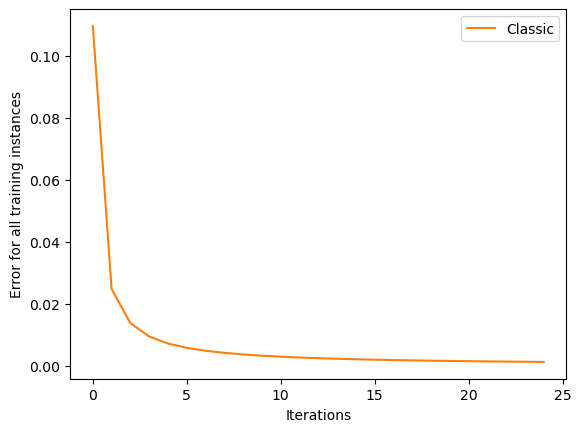

In [74]:
error_array = neural_network.batch_train(train_X_flat, train_y.T, 100, 32, 4)
print(error_array)
plt.plot(error_array, 'C1', label='Classic')
#plt.xlim(0, 2)
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error for all training instances")
